MH

Train neural network models (at least two different networks for each dataset, i.e., no. layers, no. neurons, activation, ...) in either Tensorflow or Pytorch to perform classification on the following datasets:

Fashion-MNIST

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
 
import numpy as np
import PIL
import matplotlib.pyplot as mtplt
 
print("imported!")

imported!


Import data:

Download and extract the data, then rename to cifar-10:

In [ ]:
!wget "https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-images-idx3-ubyte.gz"
!wget "https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/t10k-labels-idx1-ubyte.gz"
!wget "https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-images-idx3-ubyte.gz"
!wget "https://github.com/zalandoresearch/fashion-mnist/raw/master/data/fashion/train-labels-idx1-ubyte.gz"

In [2]:
!mkdir data
!mkdir data/fmnist
!for a in *.gz; do gunzip -c $a > data/fmnist/`echo $a | sed s/.gz//`; done

Create a dataset with manual import:

In [3]:
import warnings
from PIL import Image
import os
import os.path
import numpy as np
import torch
import codecs
import string
from typing import Any, Callable, Dict, IO, List, Optional, Tuple, Union
from torchvision.datasets.vision import VisionDataset
import gzip
import lzma

class FashionMNIST(torchvision.datasets.vision.VisionDataset):
    base_folder = 'fmnist'
    training_file = 'training.pt'
    test_file = 'test.pt'
    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
 
    @property
    def classes_names(self):
        warnings.warn("train_labels has been renamed targets")
        return self.classes

    @property
    def train_labels(self):
        warnings.warn("train_labels has been renamed targets")
        return self.targets

    @property
    def test_labels(self):
        warnings.warn("test_labels has been renamed targets")
        return self.targets

    @property
    def train_data(self):
        warnings.warn("train_data has been renamed data")
        return self.data

    @property
    def test_data(self):
        warnings.warn("test_data has been renamed data")
        return self.data
  
    def __init__(
            self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None
    ) -> None:
 
        super(FashionMNIST, self).__init__(root, transform=transform,
                                      target_transform=target_transform)
        
        self.base_folder = os.path.join(root, self.base_folder)

        self.train = train  # training set or test set
 
        if self.train:
            data_file = self.training_file
        else:
            data_file = self.test_file

        print('Processing...')
        training_set = (
            read_image_file(os.path.join(self.base_folder, 'train-images-idx3-ubyte')),
            read_label_file(os.path.join(self.base_folder, 'train-labels-idx1-ubyte'))
        )
        test_set = (
            read_image_file(os.path.join(self.base_folder, 't10k-images-idx3-ubyte')),
            read_label_file(os.path.join(self.base_folder, 't10k-labels-idx1-ubyte'))
        )
        with open(os.path.join(self.base_folder, self.training_file), 'wb') as f:
            torch.save(training_set, f)
        with open(os.path.join(self.base_folder, self.test_file), 'wb') as f:
            torch.save(test_set, f)

        print('Done!')
 
        self.data, self.targets = torch.load(os.path.join(self.base_folder, data_file))
 
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target
 
    def __len__(self) -> int:
        return len(self.data)
 
    def extra_repr(self) -> str:
        return "Split: {}".format("Train" if self.train is True else "Test")

def get_int(b: bytes) -> int:
    return int(codecs.encode(b, 'hex'), 16)

def open_maybe_compressed_file(path: Union[str, IO]) -> Union[IO, gzip.GzipFile]:
    """Return a file object that possibly decompresses 'path' on the fly.
      Decompression occurs when argument `path` is a string and ends with '.gz' or '.xz'.
    """
    if not isinstance(path, torch._six.string_classes):
        return path
    if path.endswith('.gz'):
        return gzip.open(path, 'rb')
    if path.endswith('.xz'):
        return lzma.open(path, 'rb')
    return open(path, 'rb')

SN3_PASCALVINCENT_TYPEMAP = {
    8: (torch.uint8, np.uint8, np.uint8),
    9: (torch.int8, np.int8, np.int8),
    11: (torch.int16, np.dtype('>i2'), 'i2'),
    12: (torch.int32, np.dtype('>i4'), 'i4'),
    13: (torch.float32, np.dtype('>f4'), 'f4'),
    14: (torch.float64, np.dtype('>f8'), 'f8')
}

def read_sn3_pascalvincent_tensor(path: Union[str, IO], strict: bool = True) -> torch.Tensor:
    """Read a SN3 file in "Pascal Vincent" format (Lush file 'libidx/idx-io.lsh').
      Argument may be a filename, compressed filename, or file object.
    """
    # read
    with open_maybe_compressed_file(path) as f:
        data = f.read()
    # parse
    magic = get_int(data[0:4])
    nd = magic % 256
    ty = magic // 256
    assert nd >= 1 and nd <= 3
    assert ty >= 8 and ty <= 14
    m = SN3_PASCALVINCENT_TYPEMAP[ty]
    s = [get_int(data[4 * (i + 1): 4 * (i + 2)]) for i in range(nd)]
    parsed = np.frombuffer(data, dtype=m[1], offset=(4 * (nd + 1)))
    assert parsed.shape[0] == np.prod(s) or not strict
    return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)

def read_label_file(path: str) -> torch.Tensor:
    with open(path, 'rb') as f:
        x = read_sn3_pascalvincent_tensor(f, strict=False)
    assert(x.dtype == torch.uint8)
    assert(x.ndimension() == 1)
    return x.long()

def read_image_file(path: str) -> torch.Tensor:
    with open(path, 'rb') as f:
        x = read_sn3_pascalvincent_tensor(f, strict=False)
    assert(x.dtype == torch.uint8)
    assert(x.ndimension() == 3)
    return x

Load training and test set and loaders using the previous custom dataset, then applying a normalization transform with mean and std of 0.5 for 3 channels:

In [5]:
transf = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])
 
train_set = FashionMNIST(root='./data', train=True, transform=transf)
test_set = FashionMNIST(root='./data', train=False, transform=transf)
 
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64,
                                         shuffle=False, num_workers=2)
classes = train_set.classes

Processing...
Done!
Processing...
Done!


Show some images:

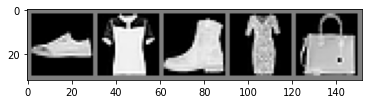

classes:  Sneaker T-shirt/top Ankle boot Dress   Bag


In [6]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    mtplt.imshow(np.transpose(npimg, (1, 2, 0)))
    mtplt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[0:5]))

print('classes: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))

Define two networks, one using a simple multi-layer fully-connected network and one using convolutional layers (CNN):

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.fc1 = nn.Linear(64 * 5 * 5, 196)
        self.fc2 = nn.Linear(196, 128)
        self.out = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.drop(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.drop(x)
        x = self.out(x)
        return x


net = Net()

In [8]:
import torch.nn.functional as F

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.linear1 = nn.Linear(1*28*28, 784)
        self.linear2 = nn.Linear(784, 1024)
        self.linear3 = nn.Linear(1024, 512)
        self.linear4 = nn.Linear(512, 256)
        self.linear5 = nn.Linear(256, 10)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        out = self.linear1(out)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        return out
net2 = Net2()

Define a Loss function and optimizer

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
import torch.optim as optim

criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(net2.parameters(), lr=0.0015, momentum=0.8)

Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
 
# Assuming that we are on a CUDA machine, this should print a CUDA device:
 
print(device)

cuda:0


In [12]:
net.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=196, bias=True)
  (fc2): Linear(in_features=196, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=10, bias=True)
)

In [13]:
from torch.autograd import Variable

epochs=10

# for later visualiztions:
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        
        # Testing the model
        if not (i % 50):
            total = 0
            correct = 0
        
            for images, label in test_loader:
                images, label = images.to(device), label.to(device)
            
                # test = Variable(images.view(16, 3, 32, 32))
                test = images
            
                output = net(test)
            
                predictions = torch.max(output, 1)[1].to(device)
                correct += (predictions == label).sum()
            
                total += len(label)
            
            accuracy = (correct * 100.0) / total
            loss_list.append(loss.data)
            iteration_list.append(i)
            accuracy_list.append(accuracy)

        # print statistics
        running_loss += loss.item()
        if not (i % 300):    # print every 100 mini-batches
            
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i, running_loss / 100))
            running_loss = 0.0
            
            print("Epoch: {}, Step: {}, Loss: {}, Accuracy: {} %"
              .format(epoch + 1, i, loss.data, accuracy)
            )

print('Finished Training')

[1,     0] loss: 0.023
Epoch: 1, Step: 0, Loss: 2.316044569015503, Accuracy: 12.079999923706055 %
[1,   300] loss: 6.646
Epoch: 1, Step: 300, Loss: 1.9714899063110352, Accuracy: 50.939998626708984 %
[1,   600] loss: 3.746
Epoch: 1, Step: 600, Loss: 0.8372088670730591, Accuracy: 67.13999938964844 %
[1,   900] loss: 2.453
Epoch: 1, Step: 900, Loss: 0.5651400089263916, Accuracy: 71.43000030517578 %
[2,     0] loss: 0.007
Epoch: 2, Step: 0, Loss: 0.7170043587684631, Accuracy: 72.33999633789062 %
[2,   300] loss: 2.100
Epoch: 2, Step: 300, Loss: 0.68874192237854, Accuracy: 74.8699951171875 %
[2,   600] loss: 1.959
Epoch: 2, Step: 600, Loss: 0.4139203727245331, Accuracy: 74.06999969482422 %
[2,   900] loss: 1.858
Epoch: 2, Step: 900, Loss: 0.7830067873001099, Accuracy: 77.18000030517578 %
[3,     0] loss: 0.007
Epoch: 3, Step: 0, Loss: 0.6851627826690674, Accuracy: 76.75 %
[3,   300] loss: 1.751
Epoch: 3, Step: 300, Loss: 0.5013720989227295, Accuracy: 77.22999572753906 %
[3,   600] loss: 1.6

In [14]:
net2.to(device)

Net2(
  (linear1): Linear(in_features=784, out_features=784, bias=True)
  (linear2): Linear(in_features=784, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=512, bias=True)
  (linear4): Linear(in_features=512, out_features=256, bias=True)
  (linear5): Linear(in_features=256, out_features=10, bias=True)
)

In [15]:
from torch.autograd import Variable

# for later visualiztions:
loss_list2 = []
iteration_list2 = []
accuracy_list2 = []


for epoch in range(epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        
        # inputs, labels = data[0], data[1]
        inputs, labels = data[0].to(device), data[1].to(device)
 
        # zero the parameter gradients
        optimizer2.zero_grad()
 
        # forward + backward + optimize
        outputs = net2(inputs)
        loss = criterion2(outputs, labels)
        loss.backward()
        optimizer2.step()
 
        
        # Testing the model
        if not (i % 50):
            total = 0
            correct = 0
        
            for images, label in test_loader:
                images, label = images.to(device), label.to(device)
            
                # test = Variable(images.view(4, 3, 32, 32))
                test = images
            
                output = net2(test)
            
                predictions = torch.max(output, 1)[1].to(device)
                correct += (predictions == label).sum()
            
                total += len(label)
            
            accuracy = (correct * 100.0) / total
            loss_list2.append(loss.data)
            iteration_list2.append(i)
            accuracy_list2.append(accuracy)

        # print statistics
        running_loss += loss.item()
        if not (i % 100):    # print every 100 mini-batches
            
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
            
            print("Epoch: {}, Step: {}, Loss: {}, Accuracy: {}%"
              .format(epoch + 1, i, loss.data, accuracy)
            )

print('Finished Training')

[1,     1] loss: 0.023
Epoch: 1, Step: 0, Loss: 2.3046960830688477, Accuracy: 9.0%
[1,   101] loss: 2.294
Epoch: 1, Step: 100, Loss: 2.288299560546875, Accuracy: 11.0%
[1,   201] loss: 2.276
Epoch: 1, Step: 200, Loss: 2.2693495750427246, Accuracy: 30.0%
[1,   301] loss: 2.246
Epoch: 1, Step: 300, Loss: 2.225290298461914, Accuracy: 34.0%
[1,   401] loss: 2.188
Epoch: 1, Step: 400, Loss: 2.1053807735443115, Accuracy: 41.0%
[1,   501] loss: 2.042
Epoch: 1, Step: 500, Loss: 1.8671149015426636, Accuracy: 33.0%
[1,   601] loss: 1.750
Epoch: 1, Step: 600, Loss: 1.6576341390609741, Accuracy: 49.0%
[1,   701] loss: 1.436
Epoch: 1, Step: 700, Loss: 1.2721002101898193, Accuracy: 51.0%
[1,   801] loss: 1.189
Epoch: 1, Step: 800, Loss: 1.178025722503662, Accuracy: 62.0%
[1,   901] loss: 1.035
Epoch: 1, Step: 900, Loss: 1.016913890838623, Accuracy: 65.0%
[2,     1] loss: 0.010
Epoch: 2, Step: 0, Loss: 0.969550609588623, Accuracy: 63.0%
[2,   101] loss: 0.900
Epoch: 2, Step: 100, Loss: 0.953308701515

Let's save our models:

In [16]:
path1 = './fashion.pth'
path2 = './fashion2.pth'
torch.save(net.state_dict(), path1)
torch.save(net2.state_dict(), path2)

 Test the network on the test data
We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the real values. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

Test Network_1 (CNN):

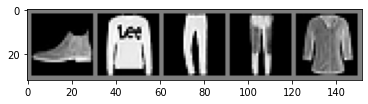

Real values:  Ankle boot Pullover Trouser Trouser Shirt


In [17]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images[0:5]))
print('Real values: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))

In [18]:
outputs = net(images.to(device))

The outputs are energies for the 10 classes. The higher the energy for a class, the more the network thinks that the image is of the particular class. So, let’s get the index of the highest energy:

In [19]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(5)))

Predicted:  Ankle boot Pullover Trouser Trouser Shirt


The second net (simple fully connected):

In [20]:
outputs2 = net2(images.to(device))
_, predicted2 = torch.max(outputs2, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted2[j]]
                              for j in range(5)))

Predicted:  Ankle boot Pullover Trouser Trouser Shirt


Let's do some evaluations:

In [21]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100.0 * correct / total))

Accuracy of the network on the 10000 test images: 85 %


And for the second net:

In [22]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net2(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100.0 * correct / total))

Accuracy of the network on the 10000 test images: 85 %


That looks way better than chance, which is 10% accuracy (randomly picking a class out of 10 classes). Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did not perform well:

CNN:

In [23]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(16):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100.0 * class_correct[i] / class_total[i]))

Accuracy of T-shirt/top : 84 %
Accuracy of Trouser : 95 %
Accuracy of Pullover : 75 %
Accuracy of Dress : 83 %
Accuracy of  Coat : 73 %
Accuracy of Sandal : 96 %
Accuracy of Shirt : 57 %
Accuracy of Sneaker : 91 %
Accuracy of   Bag : 95 %
Accuracy of Ankle boot : 94 %


Fully-Connected:

In [24]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        # images, labels = data
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net2(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(16):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100.0 * class_correct[i] / class_total[i]))

Accuracy of T-shirt/top : 84 %
Accuracy of Trouser : 94 %
Accuracy of Pullover : 73 %
Accuracy of Dress : 86 %
Accuracy of  Coat : 74 %
Accuracy of Sandal : 93 %
Accuracy of Shirt : 63 %
Accuracy of Sneaker : 91 %
Accuracy of   Bag : 95 %
Accuracy of Ankle boot : 95 %


Let's do the visualiztions I promised you:

CNN:

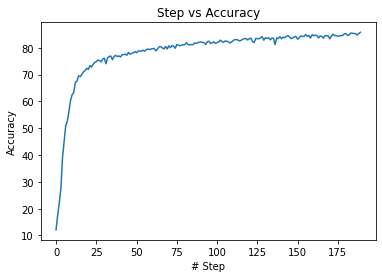

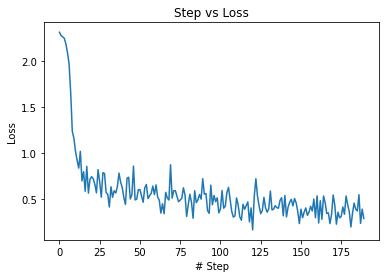

In [25]:
mtplt.plot(range(len(accuracy_list)), accuracy_list)
mtplt.xlabel("# Step")
mtplt.ylabel("Accuracy")
mtplt.title("Step vs Accuracy")
mtplt.show()

mtplt.plot(range(len(loss_list)), loss_list)
mtplt.xlabel("# Step")
mtplt.ylabel("Loss")
mtplt.title("Step vs Loss")
mtplt.show()

FC:

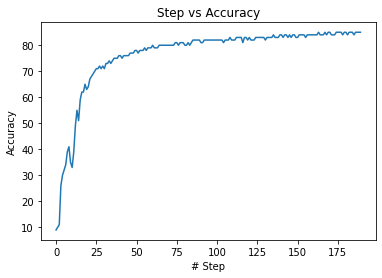

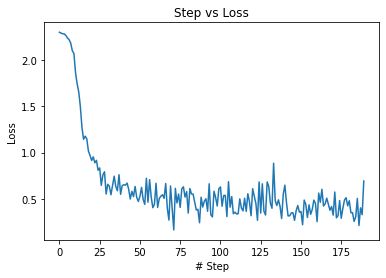

In [26]:
mtplt.plot(range(len(accuracy_list2)), accuracy_list2)
mtplt.xlabel("# Step")
mtplt.ylabel("Accuracy")
mtplt.title("Step vs Accuracy")
mtplt.show()

mtplt.plot(range(len(loss_list2)), loss_list2)
mtplt.xlabel("# Step")
mtplt.ylabel("Loss")
mtplt.title("Step vs Loss")
mtplt.show()